<h2>Экспрессивы</h2>

1<br>
Для выполнения задания я выбрал разговорный экспрессив <b>"sucks"</b>. На русский язык это слово примерно можно перевести как "отстой", "фигня".<br>
Это явный экспрессив, что можно увидеть по некоторым отличительным признакам.<br>
Во-первых, слово явно показывает субъективное негативное мнение говорящего о некотором предмете. Это мнение может не совпадать с мнением других людей, в отличие от объективных параметров предмета.<br>
Во-вторых, это слово обычно произносится на эмоциях, когда человек не в состоянии передать своё неудовлетворение обычными средствами языка.<br>
Наконец, ещё одним доводом в пользу экспрессивности данного слова можно привести то, что его действие можно усилить путём повторения (и это не будет похоже на тавтологию). Например, можно сказать: "It sucks, it really sucks", и это будет усиливать негативную оценку.<br>
Слово "sucks" выражает сугубо негативную оценку, поэтому можно предположить, что оно будет встречаться преимущественно в отрицательных отзывах, то есть будет иметь J-образный профиль с резким увеличением числа употреблений в отрицательных отзывах. Примером подобного употребления мог бы служить, например, отзыв: "This app sucks, the ads pop up every minute". Вместе с этим, не совсем понятно, насколько часто этот экспрессив будет употребляться в нейтральных отзывах. Можно предположить, что какой-то процент его употреблений будет присутствовать в отзывах типа: "Not bad. Though it sucks that the energy depletes too fast".

2.<br>
В качестве основы для корпуса был взят датасет отзывов на приложения с платформы Google Play (https://www.kaggle.com/tiquasar/playstore-reviews-google-apps). Каждое приложение имеет оценку от одной до 5 звезд, а также текст отзыва, сопровождающий оценку. Из корпуса были убраны все поля, кроме текста отзыва и оценки. Результирующий корпус можно напрямую загрузить по ссылке: https://github.com/GruffGemini/ExpressiveCorpus/raw/main/dataset.csv.

3.<br>
Теперь построим профиль экспрессива "sucks". В процессе подсчёта также будем учитывать слово "suck" (оно встречается гораздо реже, но имеет такое же значение).

Calculating log odds for rating 1


  0%|          | 0/16284 [00:00<?, ?it/s]

Log odds for rating 1 == -6.851456999322384
Calculating log odds for rating 2


  0%|          | 0/15656 [00:00<?, ?it/s]

Log odds for rating 2 == -7.550223577383351
Calculating log odds for rating 3


  0%|          | 0/31347 [00:00<?, ?it/s]

Log odds for rating 3 == -8.132416672565842
Calculating log odds for rating 4


  0%|          | 0/15800 [00:00<?, ?it/s]

Log odds for rating 4 == -8.818063628099141
Calculating log odds for rating 5


  0%|          | 0/15916 [00:00<?, ?it/s]

Log odds for rating 5 == -8.608093662731862


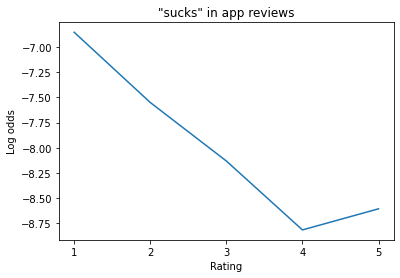

In [5]:
import matplotlib.pyplot as plt
import pickle
import requests
import os
from math import log
from nltk import word_tokenize
from nltk.corpus import stopwords
from pandas import read_csv
from tqdm.auto import tqdm

path = os.path.join('Data', 'dataset.csv')
try:
    data = read_csv(path)
except FileNotFoundError:
    print('Loading dataset...')
    os.makedirs('Data', exist_ok=True)
    r = requests.get('https://github.com/GruffGemini/ExpressiveCorpus/raw/main/dataset.csv')
    with open(path, 'wb') as f:
        f.write(r.content)
    data = read_csv(path)
log_odds = {}
stop_words = stopwords.words('english')
for rating in range(1, 6):  # поочередно рассчитываем log_odds для каждой оценки
    print(f'Calculating log odds for rating {rating}')
    rating_data = data[data['score'] == rating]  # получаем подкорпус для конкретной оценки
    reviews = rating_data['content']  # извлекаем список отзывов
    target_count = 0  # количество встретившихся слов "sucks" и "suck" для данной оценки
    total_count = 0  # количество всех слов для данной оценки
    for review in tqdm(reviews, leave=True):  # цикл по всем отзывам с данной оценкой
        try:
            prep_review = [word.lower() for word in word_tokenize(review) if
                           word not in stop_words and any(char.isalpha() for char in word)]
            # приводим все слова к нижнему регистру, исключаем стоп-слова и токены без букв (напр. знаки препинания)
            target_count += len([i for i in prep_review if i == 'suck' or i == 'sucks'])
            total_count += len(prep_review)
        except TypeError:
            pass
    log_odds[rating] = log(target_count / (total_count - target_count))
    print(f'Log odds for rating {rating} == {log_odds[rating]}')
with open(os.path.join('Data', 'log_odds.dat'), 'wb') as f:
    pickle.dump(log_odds, f)
x = range(1, 6)
plt.xticks(range(1, 6))
y = [log_odds[i] for i in x]
plt.plot(x, y)
plt.xlabel('Rating')
plt.ylabel('Log odds')
plt.title('"sucks" in app reviews')
plt.show()


4.<br>
Для описания полученных данных хорошо подходит полиномиальная регрессионная модель. Сравним аппроксимацию полиномами 2, 3 и 4 степеней:

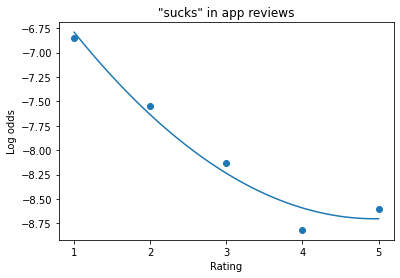

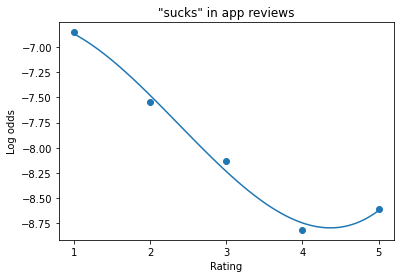

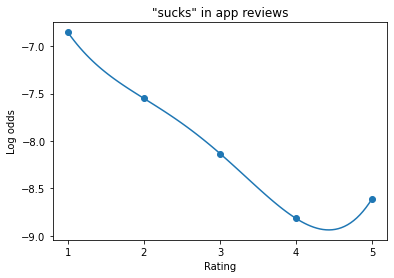

In [24]:
import matplotlib.pyplot as plt
import numpy
import pickle
with open(os.path.join('Data', 'log_odds.dat'), 'rb') as f:
    log_odds = pickle.load(f)
x = range(1,6)
y = [log_odds[i] for i in x]
line = numpy.linspace(1, 5, 100)

for degree in range(2,5):
    plt.xticks(range(1, 6))
    plt.xlabel('Rating')
    plt.ylabel('Log odds')
    plt.title('"sucks" in app reviews')
    plt.scatter(x, y)
    model = numpy.poly1d(numpy.polyfit(x, y, degree))
    plt.plot(line, model(line))
    plt.show()

В случае полинома 2-й степени кривая недостаточно хорошо описывает данные (underfitting). Кривая получается монотонно убывающей, что не отражает действительности (на оценке 5 имеем возрастание)</br>
С другой стороны, полином 4-й степени в точности повторяет данные (overfitting), и в промежутке от 1 до 4 его график меняет выпуклость на вогнутость, что также не соответствует реальной ситуации. Таким образом, наилучшим приближением будет полином 3-й степени, который достаточно хорошо отражает реальную ситуацию.

5.<br>
В целом, изначальная гипотеза подтвердилась с некоторыми оговорками. Распределение действительно имеет J-образную форму, однако резкого увеличения употреблений слова "sucks" при отрицательных отзывах не наблюдается. На участке от 4 до 1 звезды идёт плавное увеличение числа употреблений: здесь зависимость почти линейная. Однако есть небольшая неожиданность: в отзывах с оценкой 5 звезд имеется некоторое количество употреблений слова "sucks", причем их больше, чем в отзывах с 4 звездами (но меньше, чем в отзывах с 3 звездами). Попробуем рассмотреть некоторые примеры отзывов для всех оценок, чтобы выяснить причину этого явления.<br/>

Примеры отзывов с 1 звездой:<br/>
<b>"It sucks i wanted a sound amplifier and i got this. Not worth it"</b><br/>
<b>"This app sucks it's the worst app ever created my parents can just turn off my phone and I can't delete it"</b><br/>
Налицо явно эмоциональные, возможно, не полностью объективные отзывы, возникшие из-за несоответствия ожиданий, отсюда и самый высокий показатель употреблений.<br/>

Примеры отзывов с 2 звездами:<br/>
<b>"There is an error loading the page" That sucks! Samsung S20 Ultra 5G running Android 10</b><br/>
<b>On Android 6.0.1 the daily wallpaper does not change automatically and it has to be done manually. It sucks</b><br/>
Здесь имеем уже более объективные отзывы, в которых критикуются определённые недостатки. Эти недостатки считаются пользователями достаточно весомыми, отсюда связь оценки "2" и высокого числа употреблений слова "sucks"<br/>

Примеры отзывов с 3 звездами:<br/>
<b>The pricing sucks</b><br/>
<b>Service sucks in rural area Also take time to get back to Google maps</b><br/>
В подобных отзывах "sucks" относится чаще всего не к целому продукту, а к его части. В основном, пользователи, пишущие отзыв с 3 звездами, уже не так сильно расстроены, поэтому количество употреблений экспрессива довольно низко.<br/>
    
Примеры отзывов с 4 звездами:<br/>
<b>The app is amazing, but inability to add it to home screen or app drawer sucks</b><br/>
<b>Needs better app support and a smarter voice assistant (sorry google, I know you're trying, but third party integration sucks).</b><br/>
В отзывах с 4 звездами слово "sucks" встречается очень редко. Чаще всего оно относится либо к незначительным недостаткам, либо к обстоятельствам, не зависящим от разработчика приложения<br/>

Теперь попытаемся ответить на главный вопрос: откуда берутся употребления негативного экспрессива в 5-звездочных отзывах? Расмотрим примеры:<br/>
<b>Google has always been my choice of browsers, even when Microsoft was trying to force anyone who purchased a Computer with Microsoft products installed to use their browser that just plain sucks, I made sure to download Chrome so I knew I was getting the best. Thanks</b><br/>

<b>For ppl saying that it takes too long and everything 1, it doesn't happen to me and 2, its just your phone sucks and u need better data</b><br/>

<b>I loved this app. I loved being able to purchase my music. Why are you all getting rid of it?? Everything else sucks. Spotify socks, YT Music Sucks, Apple whatever sucks... I really miss this app and the availability of purchasing my music instead of downloading it. Why is my song loading if I already downloaded it?? Google Play Music didn't do that...</b><br/>

<b>This app is SO BAD i cant even deacribe it it sucks so much i only get to watch for a hour how f ing bad this quote on qoute app is for kids Bad app i rate 1</b><br/>

Можно сделать вывод, что 5-звездочные отзывы также часто пишутся на эмоциях, только в данном случае экспрессив "sucks" может быть направлен не на само приложение, а, например, на его конкурентов (человек был настолько в восторге от приложения, что в большей степени не отозвался позитивно на само приложение, а отозвался негативно на его аналоги). Также негатив может быть направлен на тех, кто негативно отзывается на приложение (как во втором примере). Отдельным случаем являются отзывы, подобные последнему. Сложно сказать, чем они вызваны. Возможно отзыв писал ребенок, не вполне понимающий, что делает. Возможно, человек был настолько разъярен, что по ошибке поставил 5 звезд. Так или иначе, совокупность всех этих факторов как раз и даёт небольшой прирост употребления слова "sucks" в 5-звездочных отзывах.